# Notebook for plotting the main shapes along the data workflow

The considered shapes to be plotted refer to the output of the following scripts:
- build_shapes
- osm_pbf_power_data_extractor
- osm_data_cleaning
- osm_built_network
- base_network
- build_bus_regions

## Load packages

In [2]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from shapely.geometry import LineString, Point
from shapely.wkt import loads
from collections import Counter

import os
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import _sets_path_to_root
_sets_path_to_root("pypsa-africa")

This is the repository path:  c:\Users\Davide\Git\pypsa-africa
Had to go 1 folder(s) up.


## Build shapes

Load build_shapes output and plot them

In [3]:
# load shapes
continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')
gadm_shapes = gpd.read_file('resources/gadm_shapes.geojson')

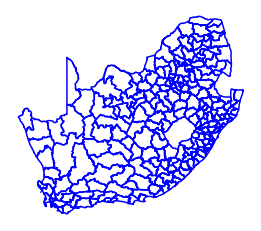

In [4]:
ax = gadm_shapes.boundary.plot(color="blue")
#off_shore.boundary.plot(ax=ax, color="green")
#continent.boundary.plot(ax=ax, color="red")
plt.axis("off")
plt.savefig("shapes_ZA.png")

## osm_pbf_power_data_extractor

Load and plot the raw data downloaded by the power extractor package

<AxesSubplot:>

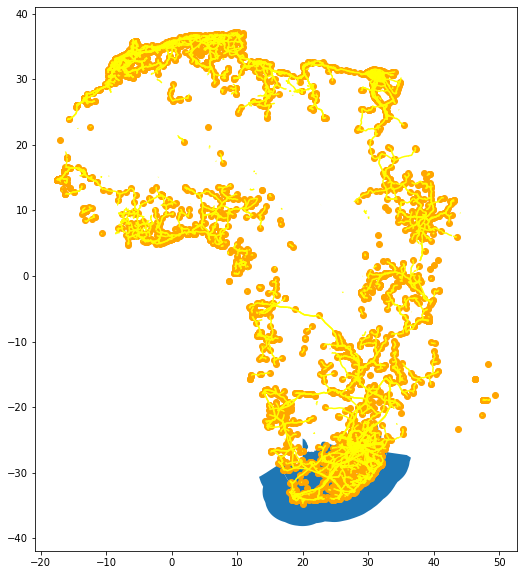

In [5]:
# plot output download_osm_data
df_substations_osm_download = gpd.read_file(os.getcwd()+"/data/raw/africa_all_raw_substations.geojson")
df_lines_osm_download = gpd.read_file(os.getcwd()+"/data/raw/africa_all_raw_lines.geojson")

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_download.plot(ax=ax, color="orange")
df_lines_osm_download.plot(ax=ax, color="yellow")
# df_lines_osm_download[df_lines_osm_download.Country == "TD"].plot(ax=ax, color="yellow")
# plt.axis("off")
# plt.savefig("network.png")

In [7]:
# df_lines_osm_download[df_lines_osm_download.Country == "TD"]#.geometry.boundary#.dropna(subset=["tags.voltage"])

,Type,Length,id,tags.power,tags.cables,tags.frequency,tags.voltage,Country,tags.circuits,geometry
5013,Way,1789.468088,189508052.0,line,None,None,None,TD,None,"LINESTRING (16.64394 7.93936, 16.64357 7.93918..."
5014,Way,184.195748,189539623.0,line,None,None,None,TD,None,"LINESTRING (16.63197 7.92742, 16.63232 7.92746..."
5015,Way,4921.607573,197946959.0,line,None,None,None,TD,None,"LINESTRING (16.79324 8.53140, 16.79208 8.52914..."
5016,Way,17415.660308,629014456.0,line,None,None,None,TD,None,"LINESTRING (16.73170 10.28553, 16.73336 10.287..."
5017,Way,800.003974,189508051.0,line,None,None,None,TD,None,"LINESTRING (16.63344 7.92929, 16.63340 7.92904..."
5018,Way,17956.492337,629014458.0,line,None,None,None,TD,None,"LINESTRING (16.84311 10.18792, 16.84316 10.188..."
5019,Way,56.883020,189539622.0,line,None,None,None,TD,None,"LINESTRING (16.63340 7.92904, 16.63332 7.92883..."
5020,Way,1254.868135,189505297.0,line,None,None,None,TD,None,"LINESTRING (16.63278 7.93229, 16.63284 7.93204..."
5021,Way,29980.114691,288799111.0,line,3,50,66000,TD,None,"LINESTRING (15.10056 12.41375, 15.10057 12.411..."
5022,Way,36.003111,189509826.0,line,None,None,None,TD,None,"LINESTRING (16.63648 7.91291, 16.63662 7.91262)"


In [64]:
# analyses buses

cnt_buses = Counter(df_substations_osm_download["tags.voltage"])

cnt_buses_outliers = {key: value for (key, value) in cnt_buses.items() if key is None or not key.isnumeric()}

cnt_buses_outliers

# sum(list(cnt_buses.values()))


{None: 4349,
 '400000;132000': 30,
 '500000;400000': 1,
 '230000;132000': 4,
 '400000;230000;132000': 1,
 '400000;230000': 1,
 '330000;161000': 7,
 '220000;110000': 22,
 '138000;63000': 1,
 '132000;66000': 20,
 '220000;132000': 15,
 '400000;60000': 1,
 '400000;220000': 16,
 '220000;60000;30000': 1,
 '60000;15000': 1,
 '220000;60000': 6,
 '400000;220000;60000': 2,
 '400000;220000;110000': 1,
 '400000;275000': 12,
 '400000;110000': 1,
 '220000;66000': 60,
 '275000;66000': 1,
 '15000;400': 2,
 '225000;90000': 21,
 '255000;90000': 1,
 '225000;150000': 4,
 '275000;132000': 39,
 '132000;11000': 5,
 '275000;88000': 20,
 '132000;88000': 16,
 '765000;400000;132000': 1,
 '400000;220000;66000': 4,
 '88000;3000': 3,
 '400000;88000': 4,
 '220000;25000': 6,
 '400000;275000;132000': 5,
 '400000;132000;66000': 5,
 '66000;11000': 1,
 '88000;25000': 1,
 '33000;6600': 3,
 '66000;33000': 2,
 '400000;275000;132000;88000': 3,
 '400000;132000;88000': 2,
 '765000;400000;275000': 1,
 '765000;400000': 5,
 '2750

In [48]:
# analyses lines

cnt_lines = Counter(df_lines_osm_download["tags.voltage"])

cnt_lines_outliers = {key: value for (key, value) in cnt_lines.items() if key is None or not key.isnumeric()}

cnt_lines_outliers


{None: 6768,
 '63KvA': 1,
 'medium': 13,
 '400000;132000': 4,
 '132000;66000': 4,
 'low': 2,
 '220000;132000': 1,
 '330000;132000': 3,
 '220000;66000': 1,
 'high-medium': 1,
 '30K_V': 2,
 '30_ك_ف': 2,
 'KV30': 1,
 '30kv': 1,
 '30;t': 1,
 '30ك_ف': 1,
 '30_K_V': 1,
 '30_KV': 1,
 '150000.': 1,
 'Avenida La Esperanza': 1,
 '220000;110000': 1,
 '66000;66000': 35,
 '2*220000': 1,
 '220000;220000': 7}

## osm_data_cleaning

Load and plot the data filtered by the osm_data_cleaning script

<AxesSubplot:>

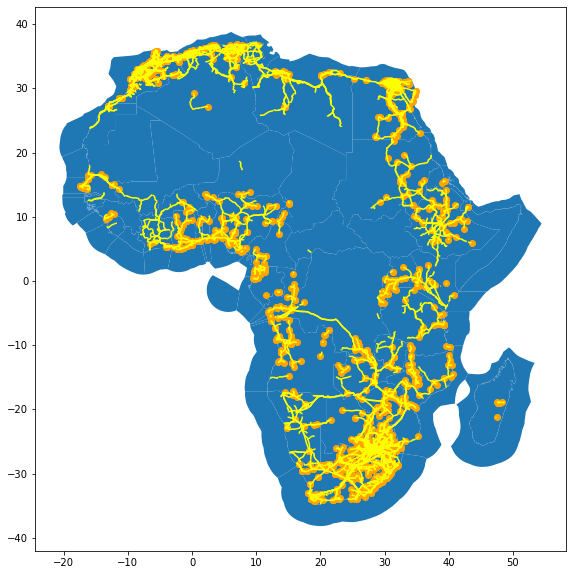

In [65]:
# plot output osm_data_cleaning
df_substations_osm_clean = gpd.read_file(os.getcwd()+"/data/clean/africa_all_substations.geojson")
df_lines_osm_clean = gpd.read_file(os.getcwd()+"/data/clean/africa_all_lines.geojson")

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_clean.plot(ax=ax, color="orange")
df_lines_osm_clean.plot(ax=ax, color="yellow")

## build_osm_network

Load and plot the data of the network constructed by the build_osm_network script

C:\ProgramData\Miniconda3\envs\toast\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<AxesSubplot:>

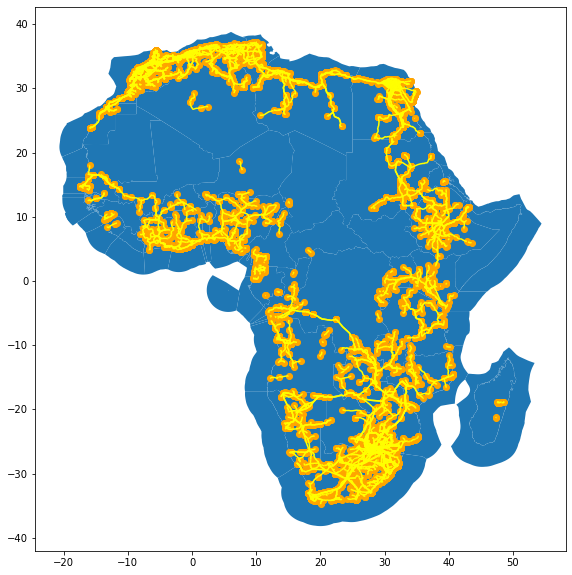

In [9]:
# plot output build_osm_network
df_substations_osm_build_network_pd = pd.read_csv(os.getcwd()+"/data/base_network/africa_all_buses_build_network.csv")
df_lines_osm_build_network_pd = pd.read_csv(os.getcwd()+"/data/base_network/africa_all_lines_build_network.csv")

df_substations_osm_build_network_pd["geometry"] = gpd.points_from_xy(df_substations_osm_build_network_pd.lon, df_substations_osm_build_network_pd.lat)
#df_lines_osm_build_network_pd.dropna(subset="geometry", inplace=True)
df_lines_osm_build_network_pd["geometry"] = df_lines_osm_build_network_pd["geometry"].map(loads)

# df_substations_osm_build_network_pd = df_substations_osm_build_network_pd[df_substations_osm_build_network_pd.country=="EH"]
#df_lines_osm_build_network_pd = df_lines_osm_build_network_pd[df_lines_osm_build_network_pd.country=="EH"]

df_substations_osm_build_network = gpd.GeoDataFrame(geometry=df_substations_osm_build_network_pd.geometry, crs='epsg:4326')
df_lines_osm_build_network = gpd.GeoDataFrame(geometry=df_lines_osm_build_network_pd.geometry, crs='epsg:4326')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_build_network.plot(ax=ax, color="orange")
df_lines_osm_build_network.plot(ax=ax, color="yellow")

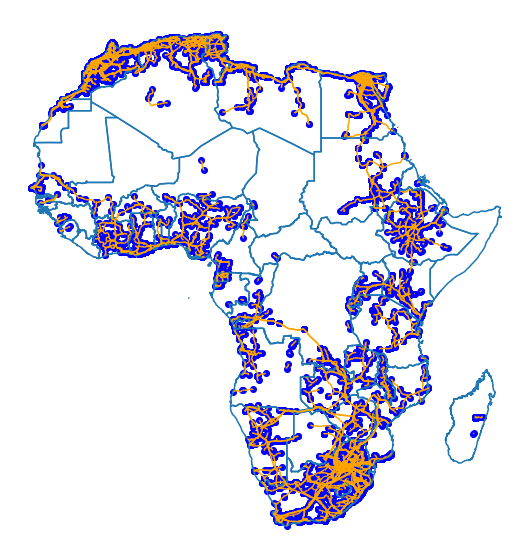

In [15]:
ax = continent.boundary.plot(figsize=(10,10))
# off_shore.plot(ax=ax)
df_substations_osm_build_network.plot(ax=ax, color="blue")
df_lines_osm_build_network.plot(ax=ax, color="orange")
plt.axis('off')
plt.savefig("map.png")


In [52]:
df_lines_osm_build_network_pd[df_lines_osm_build_network_pd.country == "CF"]#.geometry.boundary#.dropna(subset=["tags.voltage"])
#df_lines_osm_build_network_pd[df_lines_osm_build_network_pd.line_id == "452716570-1"].copy().iloc[0]
#.geometry[0].bounds
#.boundary#.iloc[7402]

,Unnamed: 0,line_id,bus0,bus1,voltage,circuits,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat
6732,6732,665129667-1,6732,22791,110000,1,83289.7582,False,False,line,50,CF,"LINESTRING (18.03385380000006 4.88041, 18.0339...","MULTIPOINT (18.03385380000006 4.88041, 18.5521...",POINT (18.03385380000006 4.88041),POINT (18.55210080000003 4.4149635),18.033854,4.88041,18.552101,4.414963


## base_network

Load and plot the data of the network model implemented in PyPSA by the base_network script

INFO:pypsa.io:Imported network base.nc has buses, lines
C:\ProgramData\Miniconda3\envs\toast\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<AxesSubplot:>

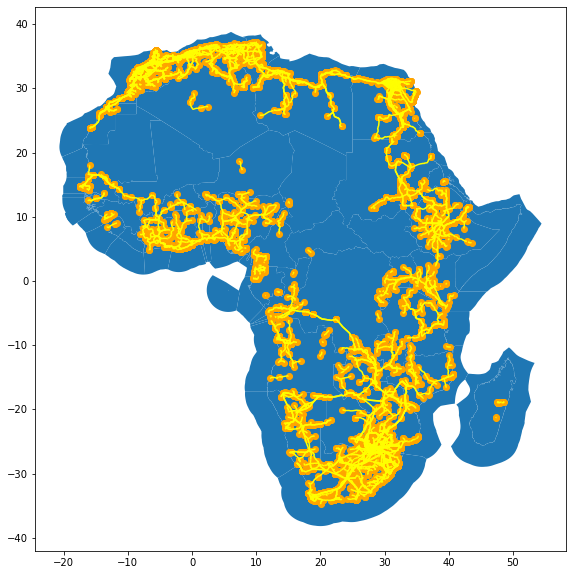

In [53]:
# plot output base_network
n = pypsa.Network(os.getcwd() + "/networks/base.nc")

lines_raw = n.lines.copy()
lines_raw["geometry"] = lines_raw["geometry"].map(loads)
# [LineString([Point(x.bus0_lon, x.bus0_lat), Point(x.bus1_lon, x.bus1_lat)]) for index, x in lines_raw.iterrows() 
#     if (x.bus0_lat is not None) and (x.bus0_lon is not None) and (x.bus1_lat is not None) and (x.bus1_lon is not None)]
lines = gpd.GeoDataFrame(geometry=lines_raw.geometry, crs='epsg:4326')

buses_raw = n.buses.copy()
buses_raw["geometry"] = gpd.points_from_xy(buses_raw.lon, buses_raw.lat)
buses = gpd.GeoDataFrame(geometry=buses_raw.geometry, crs='epsg:4326')

continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
buses.plot(ax=ax, color = "orange")
lines.plot(ax=ax, color = "yellow")


In [54]:
lines_raw[lines_raw.country == "CF"]#.geometry.boundary#.dropna(subset=["tags.voltage"])

,bus0,bus1,v_nom,num_parallel,length,underground,under_construction,tag_type,tag_frequency,country,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
665129667-1,6732,22791,220.0,1.0,83.289758,False,False,line,50,CF,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## build_bus_regions

Plot the shapes obtained with the build_bus_regions script

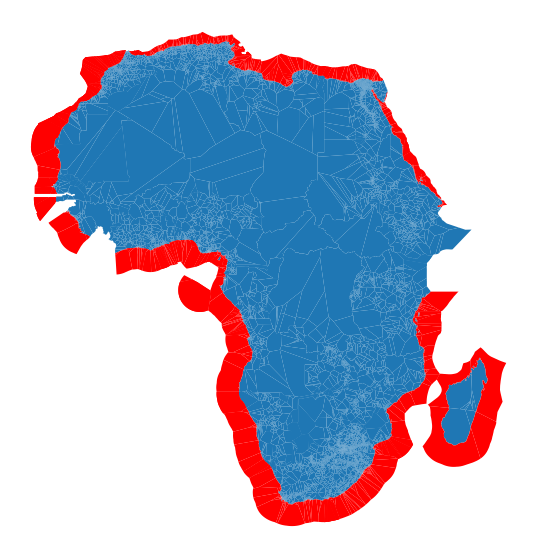

In [16]:
# plot output build_bus_regions

bus_regions_continent = gpd.read_file('resources/regions_onshore.geojson')
bus_regions_off_shore = gpd.read_file('resources/regions_offshore.geojson')

ax = bus_regions_continent.plot(figsize=(10,10))
#bus_regions_continent[bus_regions_continent.country.map(lambda x: x in ["TD", "SS", "CF", "SO"])].plot(ax=ax, color="green")
bus_regions_off_shore.plot(ax=ax, color="red")
plt.axis("off")
plt.savefig("bus_regions.png")

<AxesSubplot:>

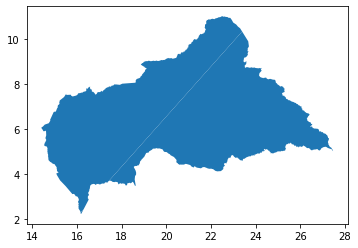

In [56]:
bus_regions_continent[bus_regions_continent.country == "CF"].plot()